In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [2]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice_old(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

In [3]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

# after looking through the slices and being very picky
good_freqs =  [538, 553, 554,
       556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569,
       571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632,
       633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700,
       702, 703, 705, 706, 707, 719, 720, 768, 799, 801, 802, 803,
       805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852,
       853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866,
       867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881,
       883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902,
       903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
       917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931,
       932, 933, 935, 936, 937, 938, 939]

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY619_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625_Corrected_amplitudes.pkl' 'FLY646_Corrected_amplitudes.pkl'
 'FLY647

# Read in a single co-added beam pickle and plot maps, slices

[538, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632, 633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700, 702, 703, 705, 706, 707, 719, 720, 768, 799, 801, 802, 803, 805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852, 853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866, 867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902, 903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931, 932, 933, 935, 936, 937, 938, 939]


<ipython-input-4-2ff729485fc1>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


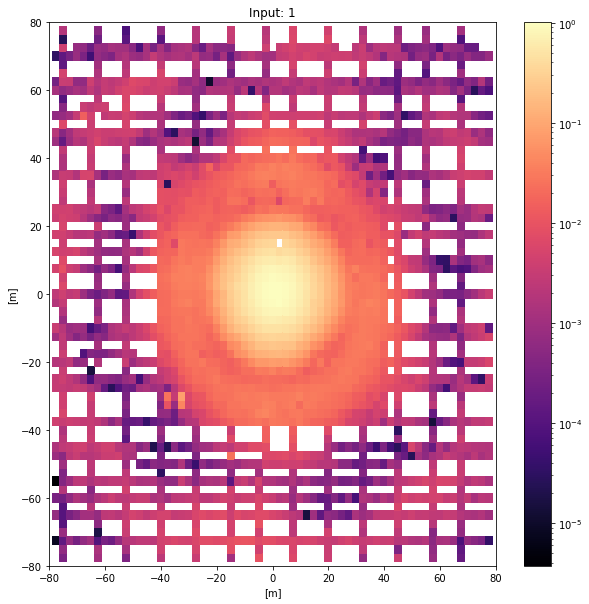

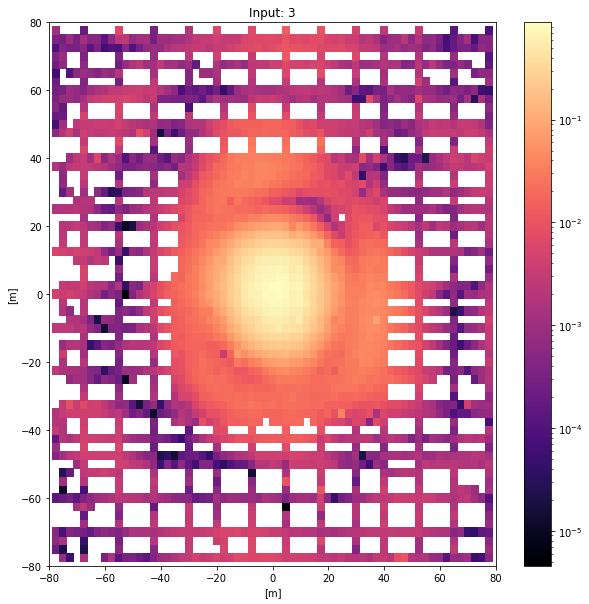

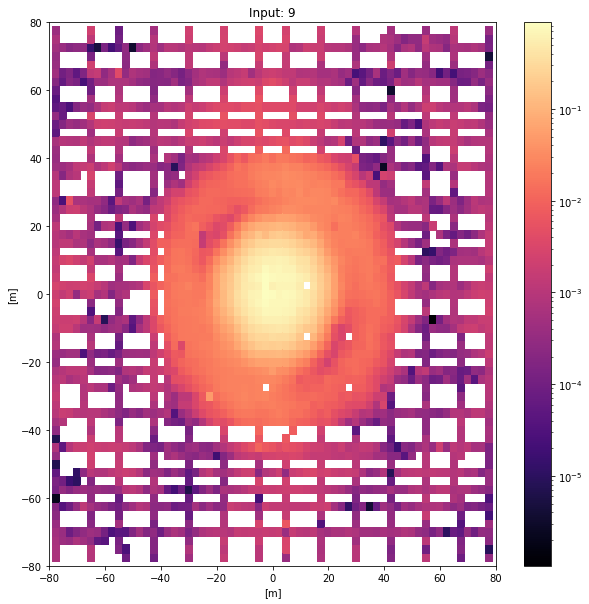

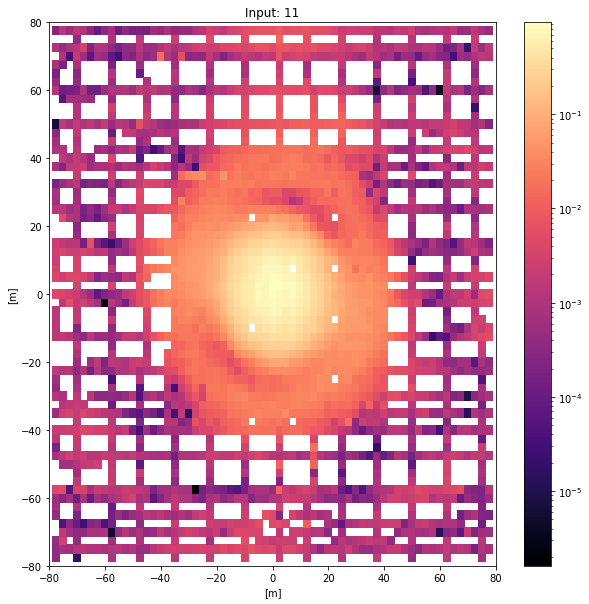

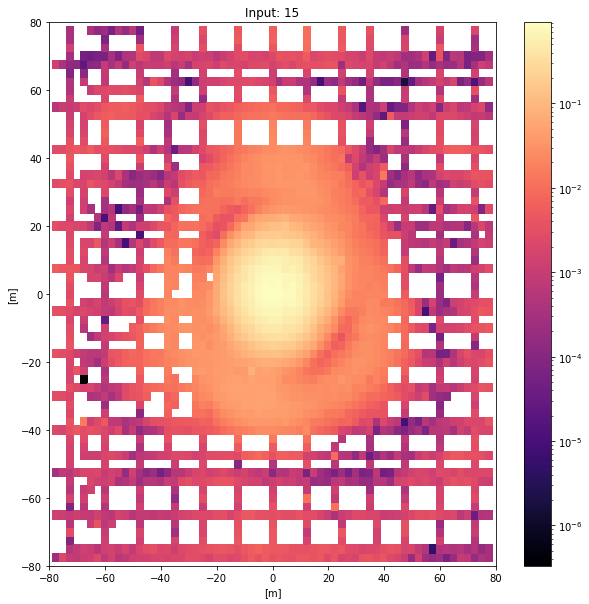

<ipython-input-4-2ff729485fc1>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


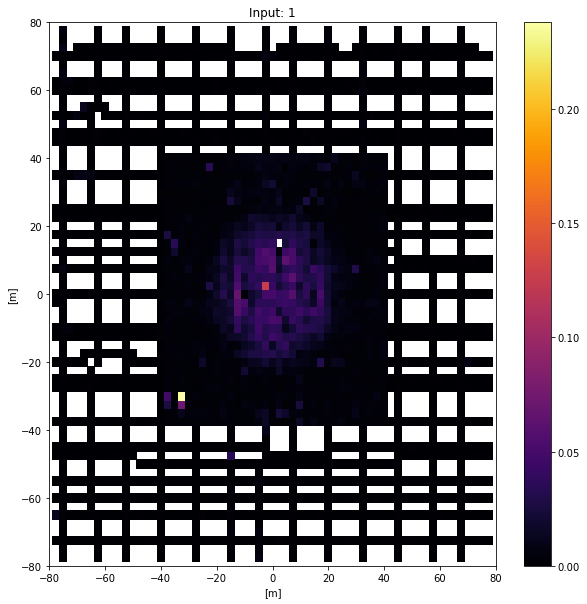

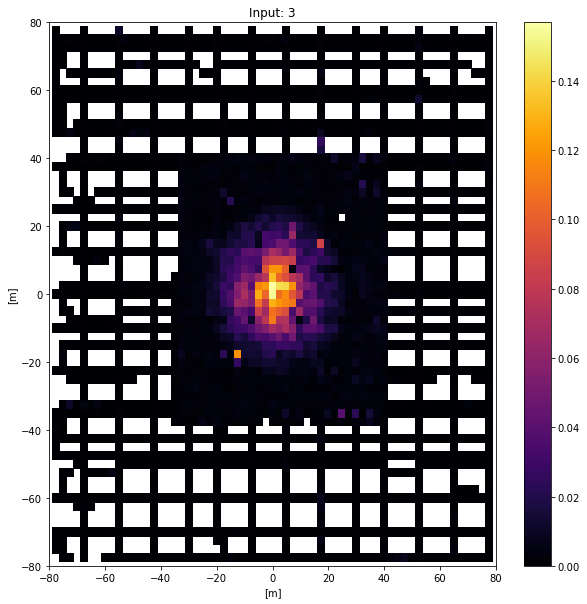

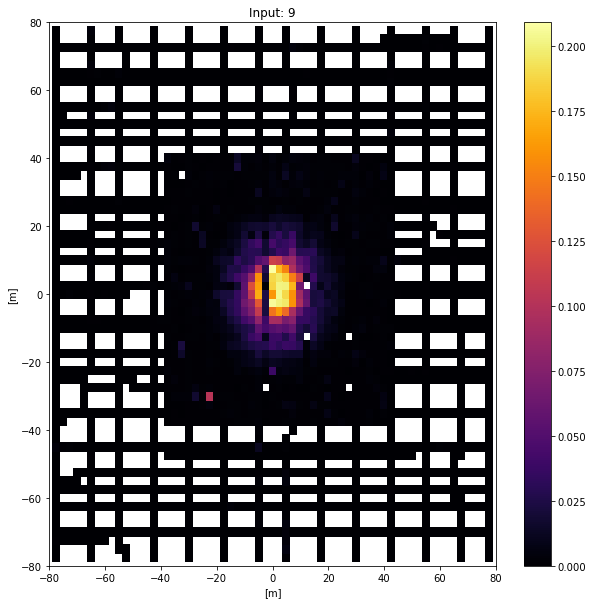

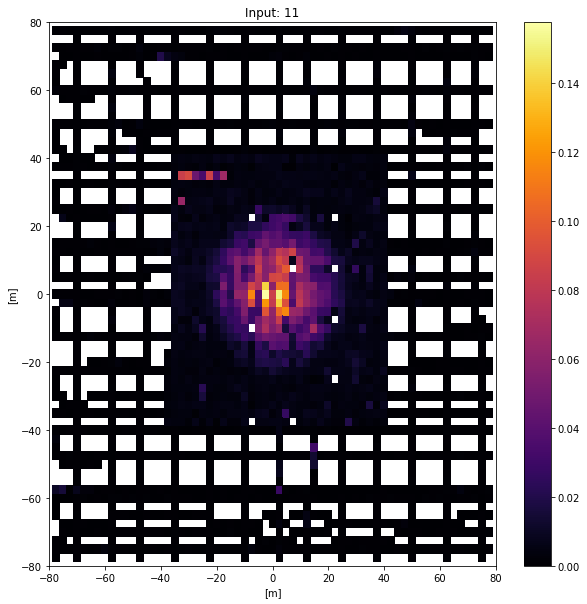

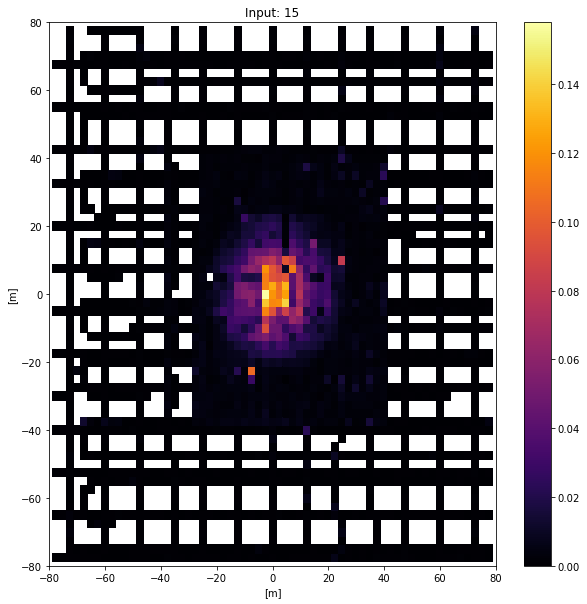

<ipython-input-4-2ff729485fc1>:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


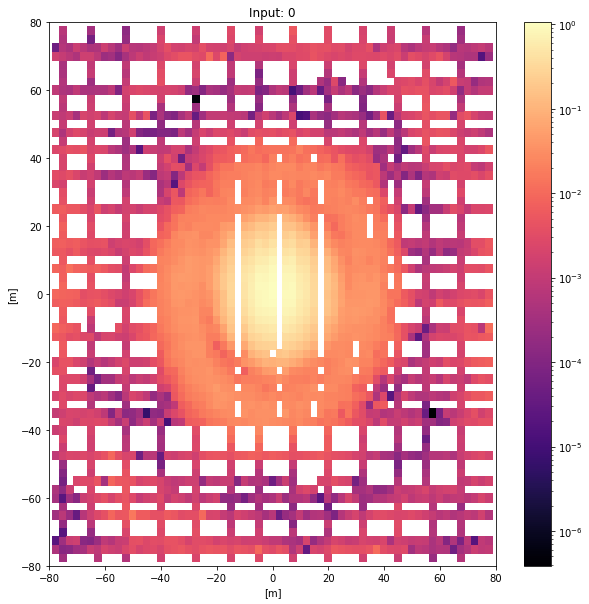

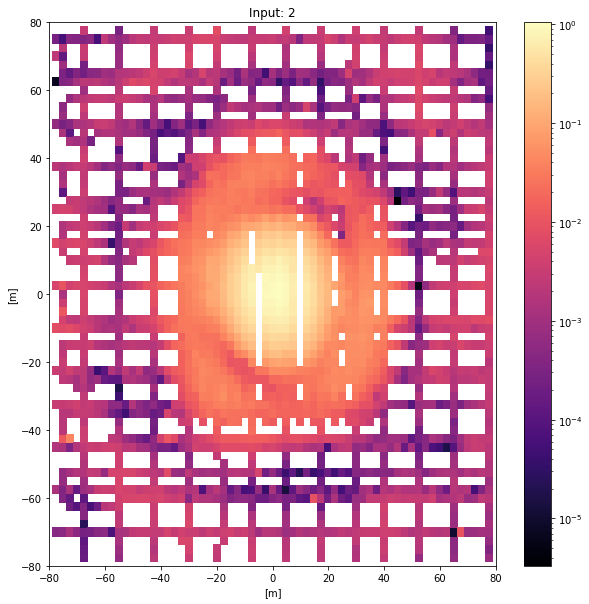

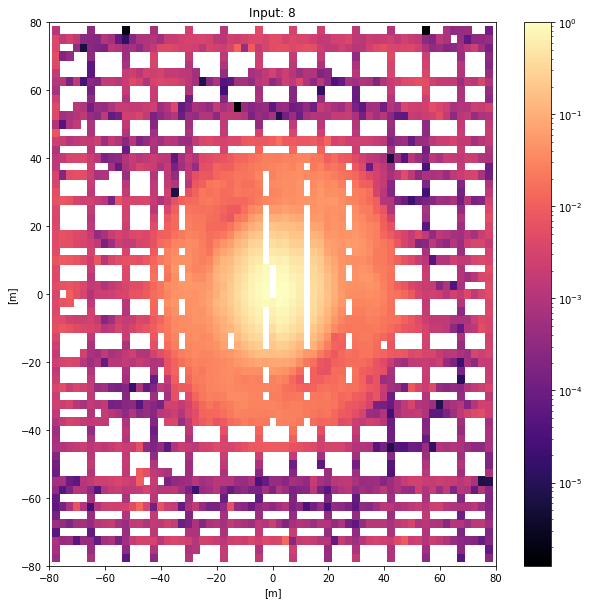

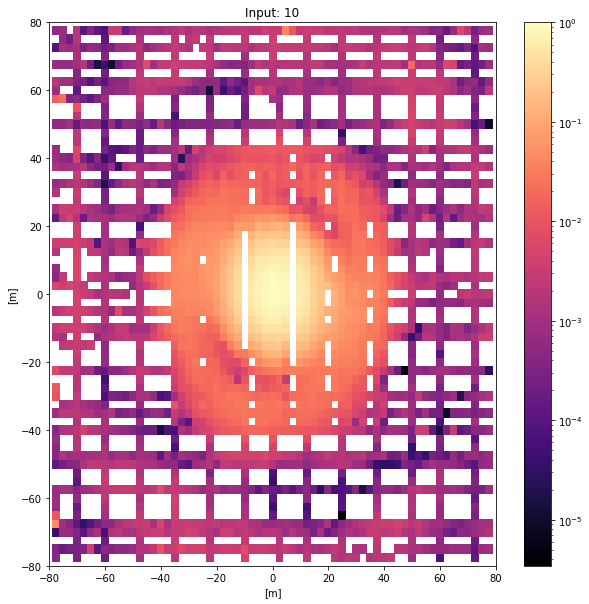

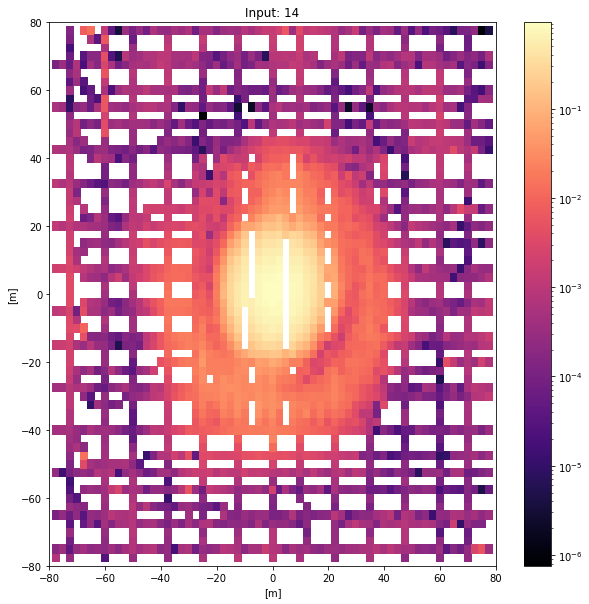

<ipython-input-4-2ff729485fc1>:64: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


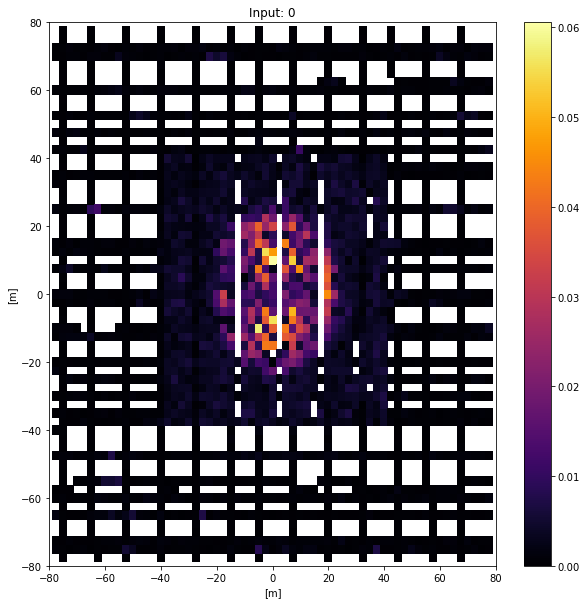

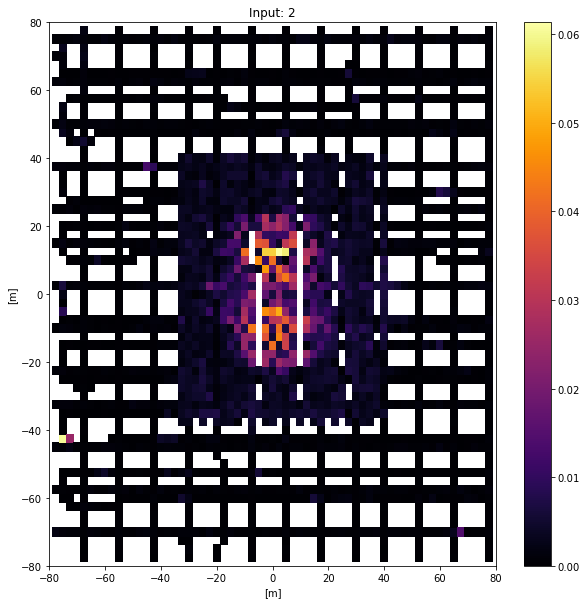

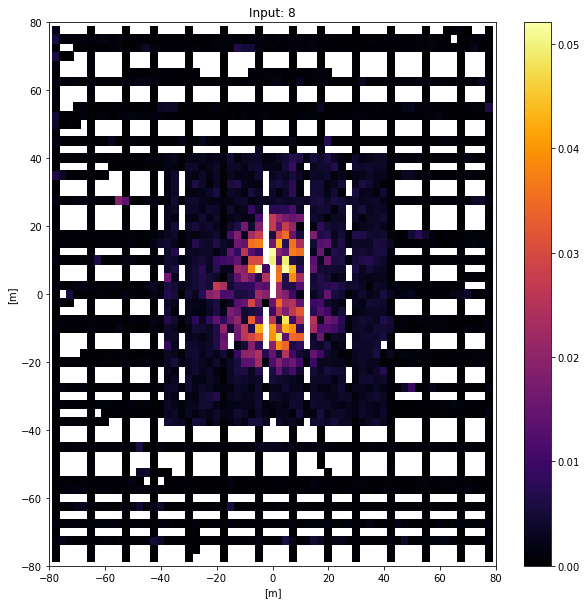

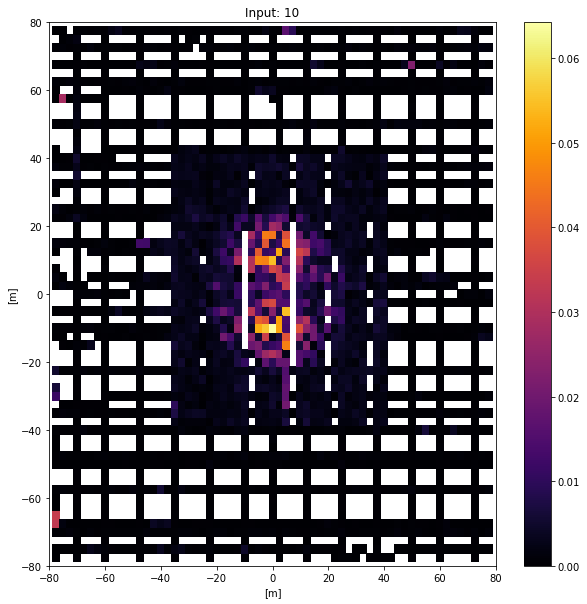

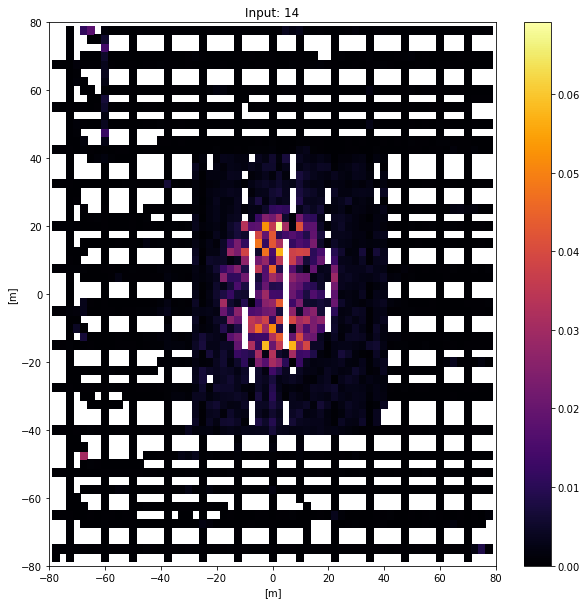

In [4]:
print(good_freqs)

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
    



448.4375


<ipython-input-39-e3ee493f25a0>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,5,1+i)
<ipython-input-39-e3ee493f25a0>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
<ipython-input-39-e3ee493f25a0>:19: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor rele

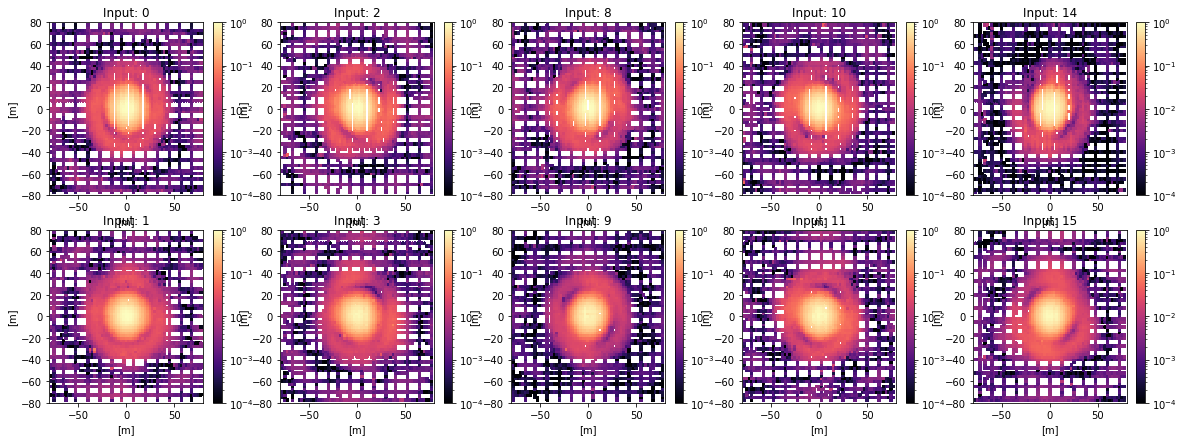

In [39]:
fig = plt.figure(figsize=(20,7))
plt.subplot(2,5,1)


copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
print(freqs[900])
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,1+i)
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    
    
# set which pol:
copoldir = 'N'
pols = N_pols

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,5+i+1)
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    

plt.show()

    
    



<ipython-input-93-3f1bef68119d>:7: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(test_rpt_r_per_dish[:,1,0],test_rpt_r_per_dish[:,2,0],c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-30,cmap=cm.magma)#,edgecolors='k')


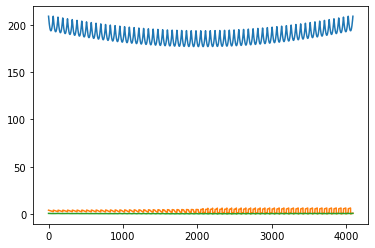

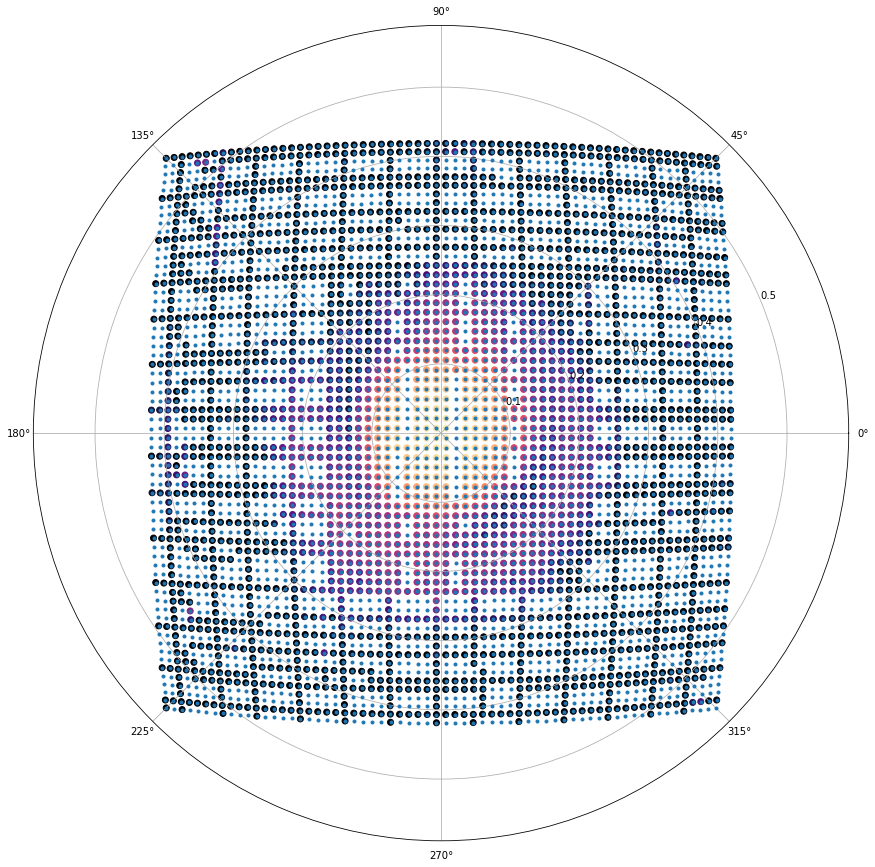

In [93]:
plot(test_rpt_r_per_dish[:,0,0])
plot(test_rpt_r_per_dish[:,1,0])
plot(test_rpt_r_per_dish[:,2,0])
fig=figure(figsize=(15,15))
ax=fig.add_subplot(111,projection='polar')
ax.plot(test_rpt_r_per_dish[:,1,0],test_rpt_r_per_dish[:,2,0],'.')
ax.scatter(test_rpt_r_per_dish[:,1,0],test_rpt_r_per_dish[:,2,0],c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-30,cmap=cm.magma)#,edgecolors='k')


In [73]:
testdat=np.zeros((int(64*64),3,16))
testdat[:,0,:]=ptest.x_centers_grid.reshape((int(64*64),16))
testdat[:,1,:]=ptest.y_centers_grid.reshape((int(64*64),16))
testdat[:,2,:]=z*np.ones((int(64*64),16))
test_rpt_r_per_dish=np.zeros((int(64*64),3,16))
rec_pointing_rot=gu.rot_mat(np.array([gu.xyz_to_rpt(ptest.dish_pointings[i])[2],0.0,gu.xyz_to_rpt(ptest.dish_pointings[i])[1]]))
for i in range(16):
    test_rpt_r_per_dish[:,:,i]=np.array([gu.xyz_to_rpt(rec_pointing_rot@testdat[k,:,i]) for k in range(len(testdat))])


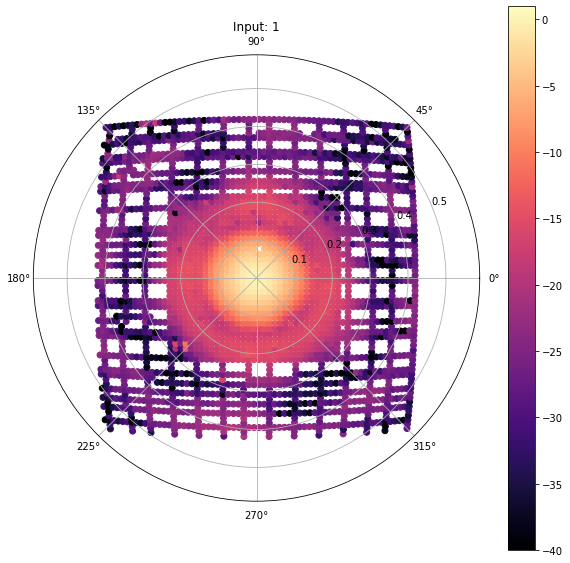

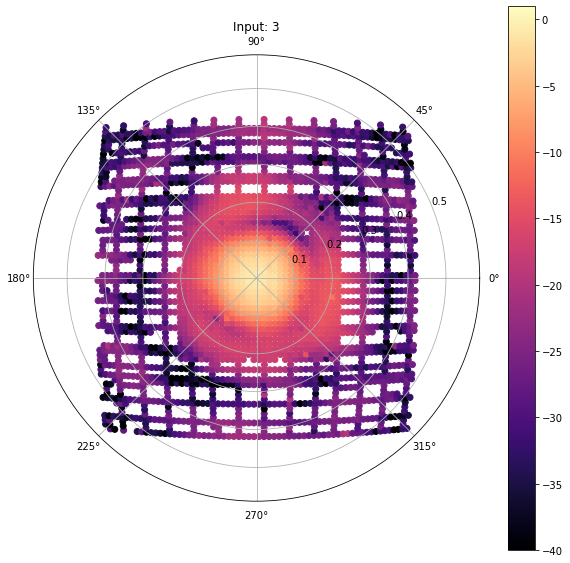

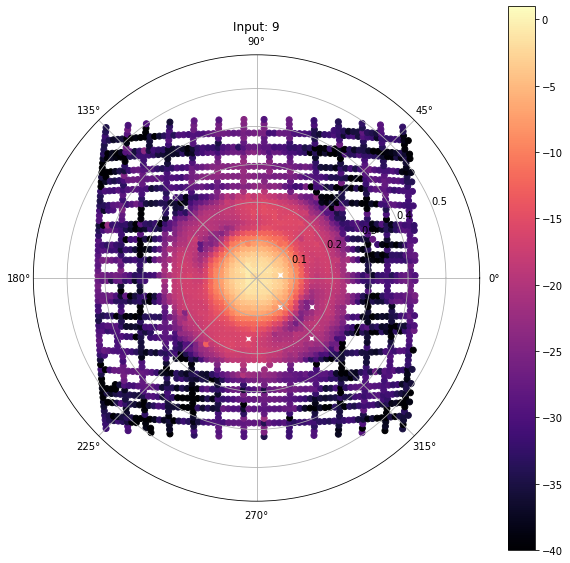

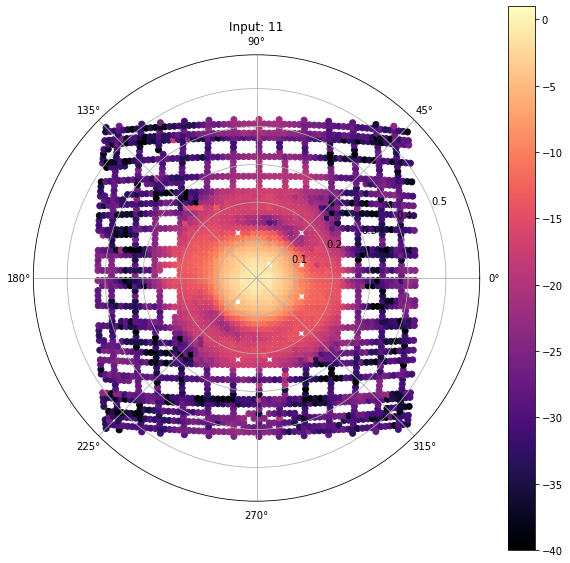

<ipython-input-96-918720b38453>:21: RuntimeWarning: divide by zero encountered in log10
  c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')


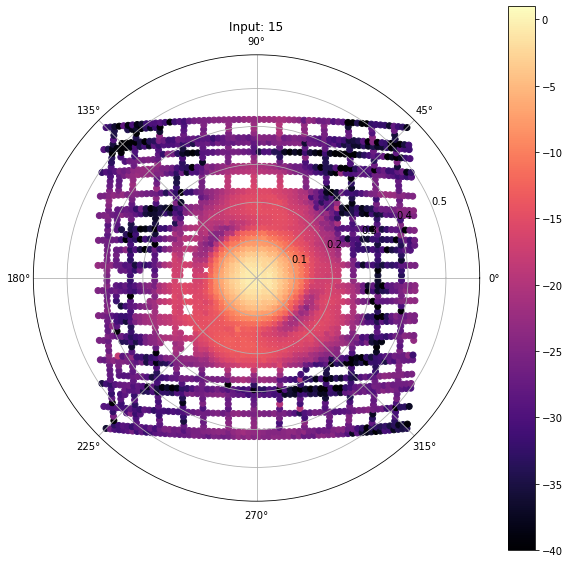

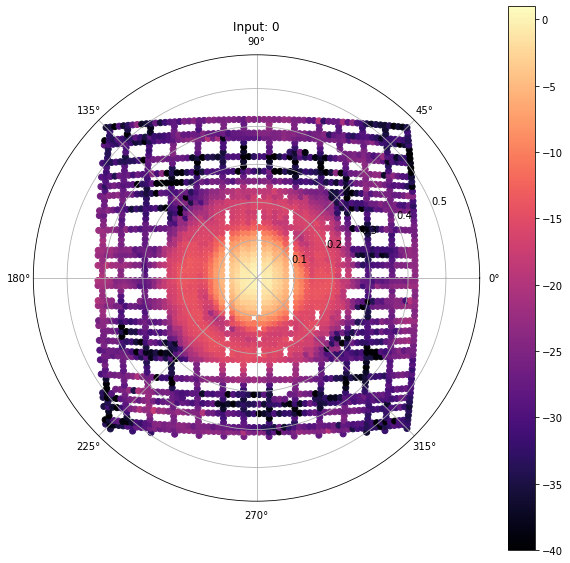

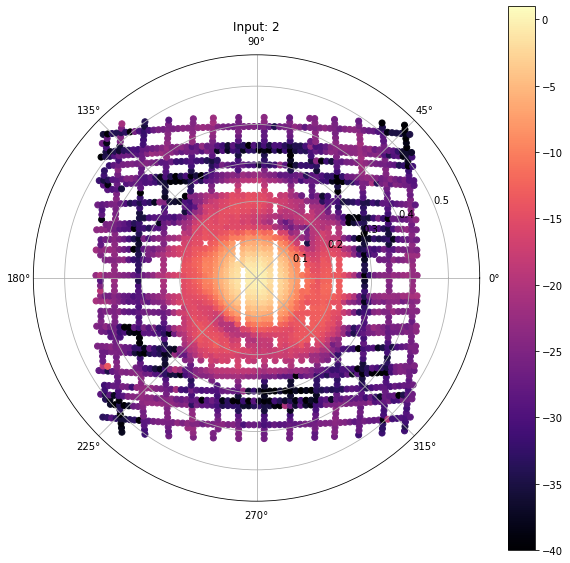

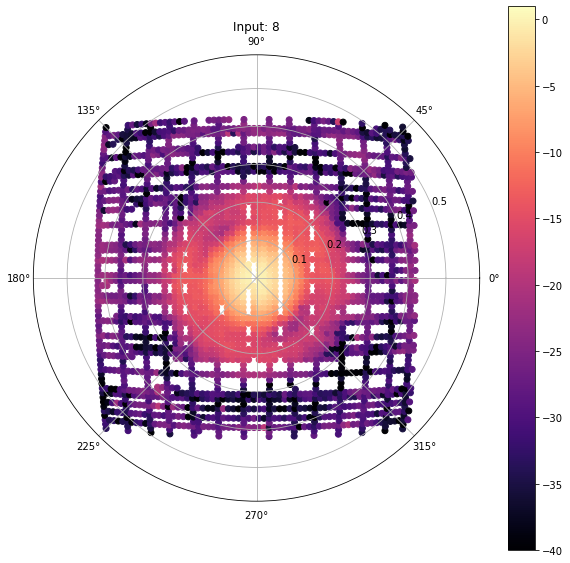

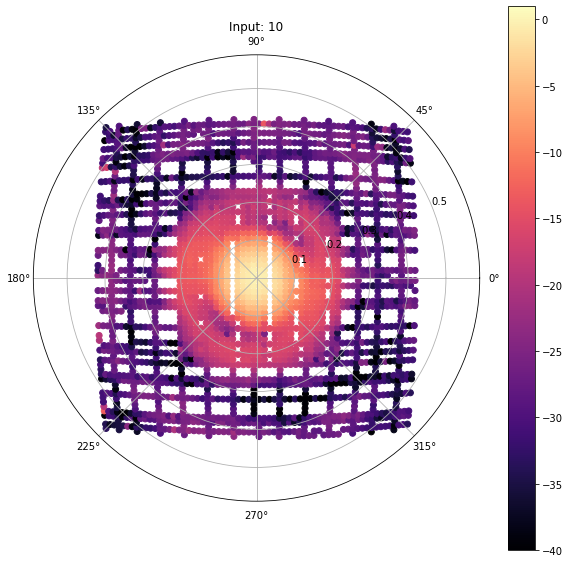

<ipython-input-96-918720b38453>:44: RuntimeWarning: divide by zero encountered in log10
  c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')


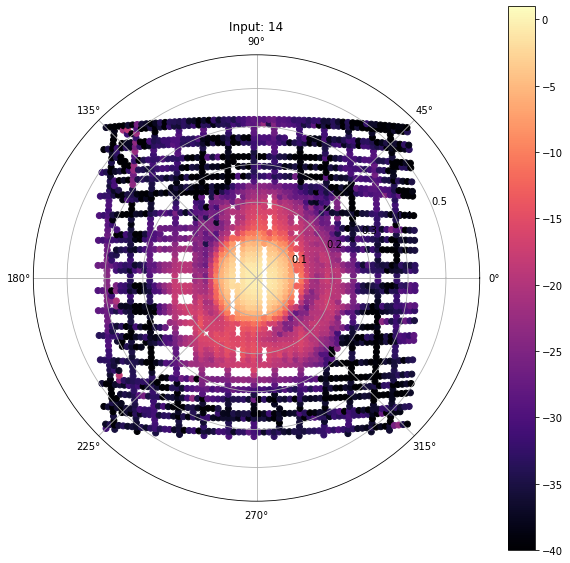

In [96]:



# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
z=177.
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    x = ptest.x_centers_grid[:,:,chind]
    y = ptest.y_centers_grid[:,:,chind]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(x / np.sqrt(x**2 + y**2))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(phi,theta,
               c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    x = ptest.x_centers_grid[:,:,chind]
    y = ptest.y_centers_grid[:,:,chind]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(x / np.sqrt(x**2 + y**2))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(phi,theta,
               c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

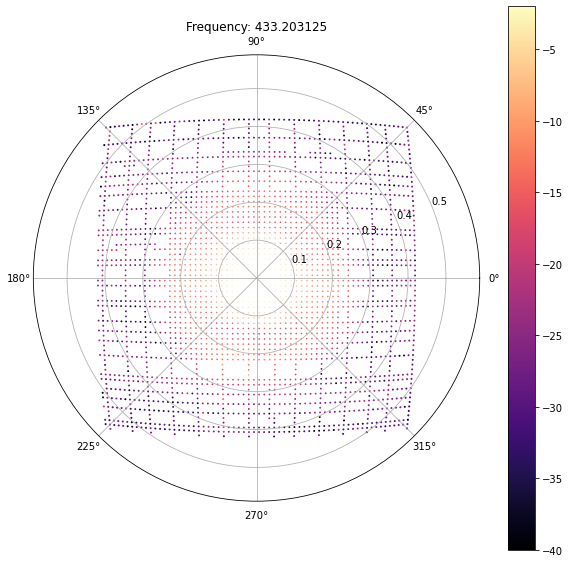

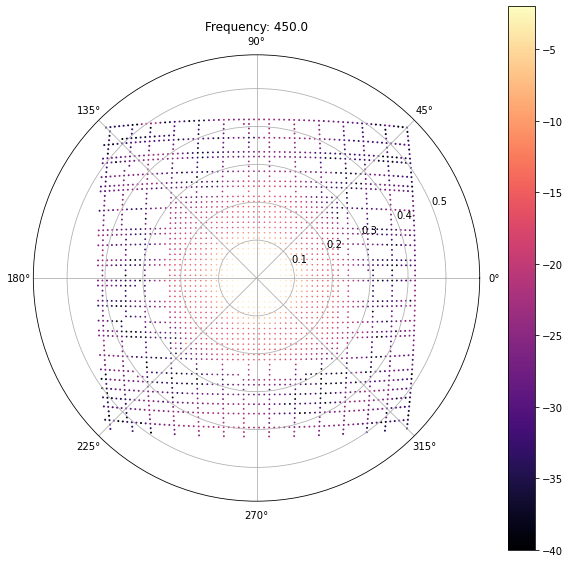

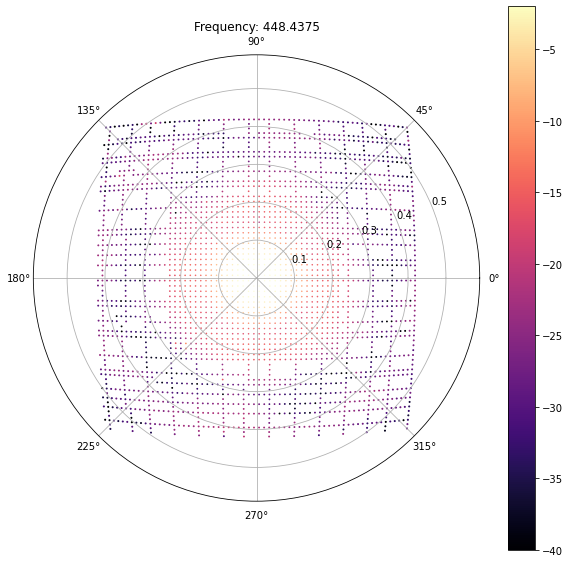

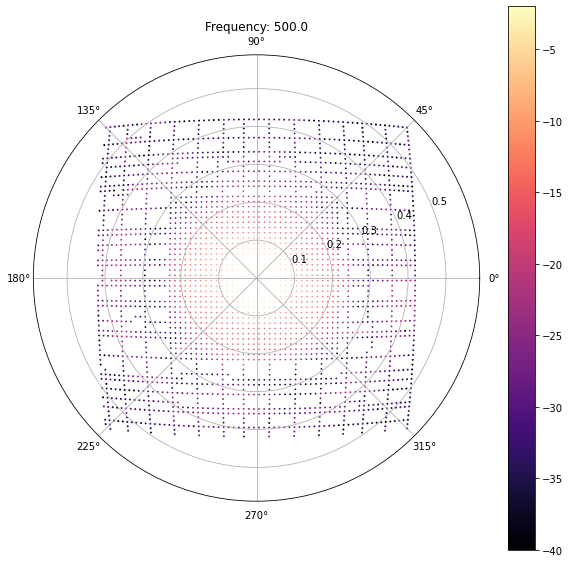

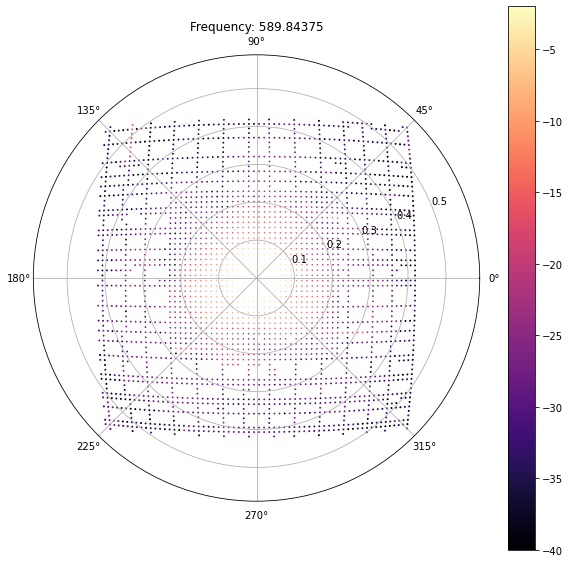

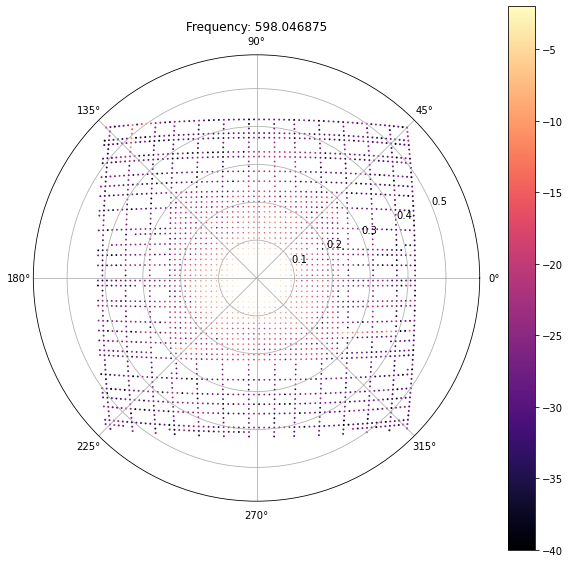

In [98]:
# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900

z=177 
chind = pols[0]
    
for f,find in enumerate([939,896,900,768,538,517]):
    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    x = ptest.x_centers_grid[:,:,chind]
    y = ptest.y_centers_grid[:,:,chind]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(x / np.sqrt(x**2 + y**2))
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(phi,theta,
               c=10*np.log10(np.abs(ptest.V_LC_operation[lb:ub,lb:ub,0,chind])),
                vmax=-2,vmin=-40,s=theta*2,cmap=cm.magma)#,edgecolors='k')
    plt.title('Frequency: '+str(freqs[find]))
    plt.colorbar()
    plt.show()
    


Text(0.5, 0.98, 'Freq ind900 Freq 448.4375')

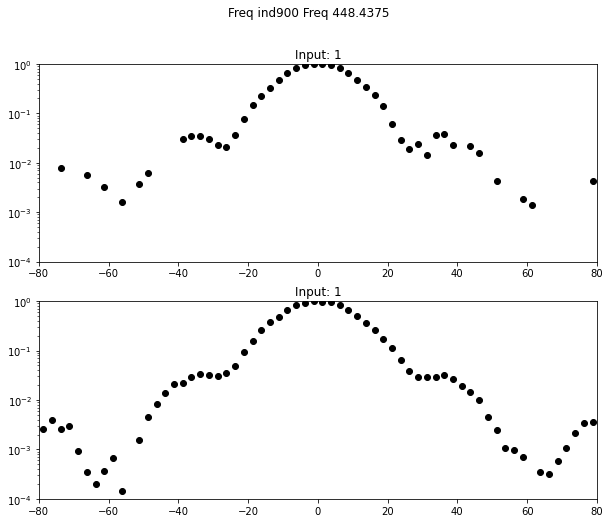

In [10]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.x_centers_grid[colx,0,0]),color='black')
plt.title('Input: '+str(chind))
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
#plt.legend(loc='lower center')
plt.subplot(2,1,2)
plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.title('Input: '+str(chind))
#plt.legend(loc='lower center')
plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))



In [54]:
Npolflights = ['618','619','623','625','646','647','533','536']
Epolflights = ['620','648','649','535']

pflights=Npolflights
find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,16,len(pflights)])

for i, fly in enumerate(pflights):

    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

    if fly == '618':
        normarr[:,:,:,i] = 1.0
    elif fly == '620':
        normarr[:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    elif fly in Epolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    flightarr[:,:,:,i] = beam.V_LC_mean[:,:,0,:,0]*normarr[:,:,:,i]

618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
start of big ass loop is: 2023-10-17 13:23:03.412546
end of chan/freq loop is: 2023-10-17 13:23:06.497153       


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:329: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


619 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl'>
start of big ass loop is: 2023-10-17 13:23:13.410172
end of chan/freq loop is: 2023-10-17 13:23:16.687683       
623 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY623_20211021T203206Z_ver_20231012T014921_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY623_20211021T203206Z_ver_20231012T014921_concat.pkl'>
start of big ass loop is: 2023-10-17 13:23:23.526943
end of chan/freq loop is: 2023-10-17 13:23:27.393402       
625 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_ver_20231012T020905_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_

Text(0.5, 0.98, 'Frequency 448.4375 MHz')

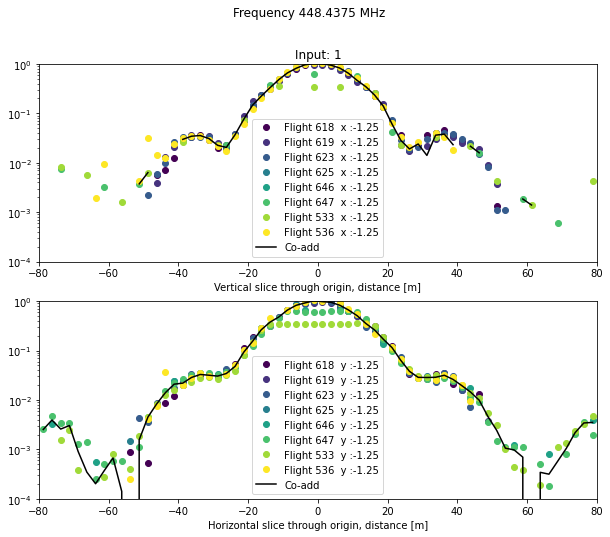

In [20]:
colors=pu.cm_to_discrete('viridis', len(pflights))

xx = 0
chind = pols[0]
colx = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'h')
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
for i,p in enumerate(pflights):
    plt.semilogy(beam.y_centers_grid[colx,:,0],flightarr[colx,:,chind,i],'o',
             color=colors[i],label='Flight '+str(p)+'  x :'+str(beam.x_centers_grid[colx,0,0]))
    plt.title('Input: '+str(chind))
plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],
             label='Co-add',color='black')
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Vertical slice through origin, distance [m]')
plt.legend(loc='lower center')

plt.subplot(2,1,2)
for i,p in enumerate(pflights):
    plt.semilogy(beam.x_centers_grid[:,coly,0],flightarr[:,coly,chind,i],'o',
             color=colors[i],label='Flight '+str(p)+'  y :'+str(beam.y_centers_grid[0,coly,0]))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],
             label='Co-add',color='black')
plt.xlabel('Horizontal slice through origin, distance [m]')
plt.legend(loc='lower center')
plt.suptitle('Frequency '+str(freqs[find])+' MHz')

Text(0.5, 0.98, 'Frequency 448.4375 MHz')

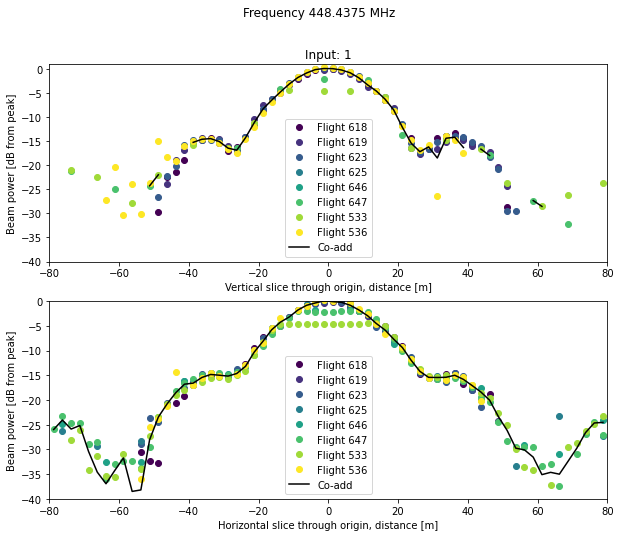

In [58]:
colors=pu.cm_to_discrete('viridis', len(pflights))

xx = 0
chind = pols[0]
colx = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'h')
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
for i,p in enumerate(pflights):
    plt.plot(beam.y_centers_grid[colx,:,0],10*np.log10(abs(flightarr[colx,:,chind,i])),'o',
             color=colors[i],label='Flight '+str(p))
    plt.title('Input: '+str(chind))
plt.plot(beam_coad.y_centers_grid[colx,:,chind],10*np.log10(np.abs(beam_coad.V_LC_operation[colx,:,0,chind])),
             label='Co-add',color='black')
plt.ylim(-40,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Vertical slice through origin, distance [m]')
plt.ylabel('Beam power [dB from peak]')
plt.legend(loc='lower center')

plt.subplot(2,1,2)
for i,p in enumerate(pflights):
    plt.plot(beam.x_centers_grid[:,coly,0],10*np.log10(abs(flightarr[:,coly,chind,i])),'o',
             color=colors[i],label='Flight '+str(p))
    plt.ylim(-40,0)
    plt.xlim(-1*sz,sz)
plt.plot(beam_coad.x_centers_grid[:,coly,0],10*np.log10(abs(beam_coad.V_LC_operation[:,coly,0,chind])),
             label='Co-add',color='black')
plt.xlabel('Horizontal slice through origin, distance [m]')
plt.ylabel('Beam power [dB from peak]')
plt.legend(loc='lower center')
plt.suptitle('Frequency '+str(freqs[find])+' MHz')

Text(0.5, 0.98, 'Frequency 598.046875 MHz')

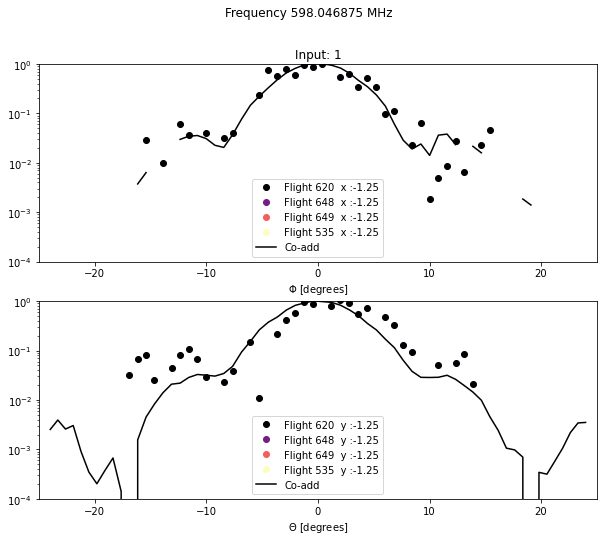

In [53]:
colors=pu.cm_to_discrete('viridis', len(pflights))

xx = 0
chind = pols[0]
colx = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'h')
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
for i,p in enumerate(pflights):
    phi = np.degrees(np.arctan2(beam.y_centers_grid[colx,:,0],177))
    plt.semilogy(phi,flightarr[colx,:,chind,i],'o',
             color=colors[i],label='Flight '+str(p)+'  x :'+str(beam.x_centers_grid[colx,0,0]))
    plt.title('Input: '+str(chind))
phi = np.degrees(np.arctan2(beam_coad.y_centers_grid[colx,:,chind],177))
plt.semilogy(phi,beam_coad.V_LC_operation[colx,:,0,chind],
             label='Co-add',color='black')
plt.ylim(0.0001,1)
plt.xlim(-25,25)
plt.legend(loc='lower center')
plt.xlabel('$\Phi$ [degrees]')

plt.subplot(2,1,2)
for i,p in enumerate(pflights):
    phi = np.degrees(np.arctan2(beam.x_centers_grid[:,coly,0],177))
    plt.semilogy(phi,flightarr[:,coly,chind,i],'o',
             color=colors[i],label='Flight '+str(p)+'  y :'+str(beam.y_centers_grid[0,coly,0]))
plt.ylim(0.0001,1)
plt.xlim(-25,25)
phi = np.degrees(np.arctan2(beam_coad.x_centers_grid[:,coly,0],177))
plt.semilogy(phi,beam_coad.V_LC_operation[:,coly,0,chind],
             label='Co-add',color='black')
plt.legend(loc='lower center')
plt.xlabel('$\Theta$ [degrees]')
plt.suptitle('Frequency '+str(freqs[find])+' MHz')

In [34]:
Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

pflights=Npolflights
find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,16,len(pflights)])

for i, fly in enumerate(Npolflights):

    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

    if fly == '618':
        normarr[:,:,:,i] = 1.0
    elif fly == '620':
        normarr[:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    elif fly in Epolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    flightarr[:,:,:,i] = beam.V_LC_mean[:,:,0,:,0]*normarr[:,:,:,i]




618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
start of big ass loop is: 2023-10-17 09:51:17.281601
end of chan/freq loop is: 2023-10-17 09:51:19.635704       
619 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl'>
start of big ass loop is: 2023-10-17 09:51:24.394314
end of chan/freq loop is: 2023-10-17 09:51:27.958430       
625 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_ver_20231012T020905_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_

<ipython-input-35-33449ca4c5b9>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
<ipython-input-35-33449ca4c5b9>:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],


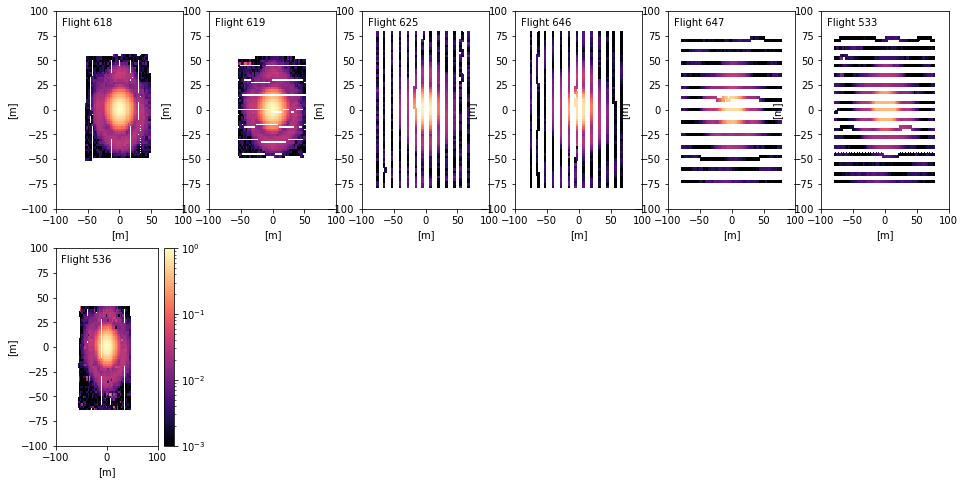

In [35]:
fig = plt.figure(figsize=(16,8))

# Npol flights
chind = pols[0]
for p,pp in enumerate(Npolflights):
    plt.subplot(2,6,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(flightarr[:,:,chind,p]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Flight '+str(pp))
    plt.xlabel('[m]')
    plt.ylabel('[m]')
plt.colorbar()
plt.show()

In [36]:
pflights=Epolflights
find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,16,len(pflights)])

for i, fly in enumerate(Epolflights):
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

    if fly == '618':
        normarr[:,:,:,i] = 1.0
    elif fly == '620':
        normarr[:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    elif fly in Epolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    flightarr[:,:,:,i] = beam.V_LC_mean[:,:,0,:,0]*normarr[:,:,:,i]





620 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl'>
start of big ass loop is: 2023-10-17 09:52:25.686782
end of chan/freq loop is: 2023-10-17 09:52:28.133449       
648 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 40
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY648_20211022T191922Z_ver_20231012T031117_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY648_20211022T191922Z_ver_20231012T031117_concat.pkl'>
start of big ass loop is: 2023-10-17 09:52:33.260651
end of chan/freq loop is: 2023-10-17 09:52:37.054499       
649 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 40
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY649_20211022T194308Z_ver_20231012T033021_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY649_20211022T194308Z_

<ipython-input-37-63cff66c1ed0>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
<ipython-input-37-63cff66c1ed0>:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],


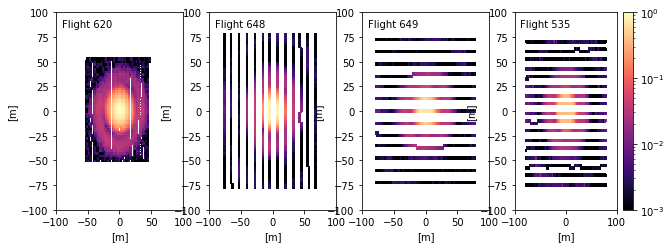

In [37]:
fig = plt.figure(figsize=(16,8))
pols=E_pols

# Epol flights
chind = pols[0]
for p,pp in enumerate(Epolflights):
    plt.subplot(2,6,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(flightarr[:,:,chind,p]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Flight '+str(pp))
    plt.xlabel('[m]')
    plt.ylabel('[m]')
plt.colorbar()
plt.show()

# Gaussian fit the co-added maps above

In [ ]:
#### LEAST SQUARES FITTING #####


#restr = 18
# read in all N pol co-adds

print(good_freqs)
G_popt = np.zeros([16,1024,6])
pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])

# set which pol:
copoldir = 'N'
pols = N_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x

copoldir = 'E'
pols = E_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x


In [ ]:
pols = N_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

pols = E_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

In [ ]:
print(G_popt.x)
print(G_popt.jac.shape)

J = G_popt.jac
cov = np.linalg.inv(J.T.dot(J))
var = np.diagonal(cov)
stdd = np.sqrt(var)
print(stdd)

# sneaky? scale by chi2:
chi2dof = np.sum(G_popt.fun**2)/(G_popt.fun.size - G_popt.x.size)
cov *= chi2dof
perr = np.sqrt(np.diag(cov))    # 1sigma uncertainty on fitted parameters
print(perr)

# more robust to off-diagonals
from scipy import linalg

U, s, Vh = linalg.svd(G_popt.jac, full_matrices=False)
tol = np.finfo(float).eps*s[0]*max(G_popt.jac.shape)
w = s > tol
cov = (Vh[w].T/s[w]**2) @ Vh[w]  # robust covariance matrix
perr = np.sqrt(np.diag(cov))     # 1sigma uncertainty on fitted parameters
print(perr)

# no change, who cares

In [ ]:
#### PLAYING AROUND WITH EMCEE

In [ ]:
# This combines all of the emcee stuff into functions:
### ONLY NEED TO RUN THIS ONCE #########
## Fit the coadded maps with a Gaussian, emcee it for errors, and save that

import emcee

def model(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    #xsig,ysig = P
    xx = ((x-x0)**2)/(2*(xsig**2))
    yy = ((y-y0)**2)/(2*(ysig**2))
    return amp*np.exp(-1.0*(xx + yy))+c

def lnlike(P,x,y,V,Verr):
    LnLike = -0.5*np.nansum(((model(P,x,y)-V)/Verr)**2)
    return LnLike

def lnprior(P):
    amp,x0,xsig,y0,ysig,c=P
    if x0>-1 and x0<1 and y0>-1 and y0<1 and c<0.1 and xsig>5.0 and xsig<12.0 and ysig>5.0 and ysig<12.0 and amp>-1.5 and amp<1.5:
        return 0.0
    else:
        return -np.inf

def lnprob(P,x,y,V,Verr):
    lp = lnprior(P)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(P,x,y,V,Verr) #recall if lp not -inf, its 0, so this just returns likelihood



def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state


def get_ml_solns(mbx,mby,mbV,mbVerr,gi):
    pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])
    nwalkers = 500
    data = (mbx[gi],mby[gi],mbV[gi],mbVerr[gi])
    niter = 500
    ndim = len(pG)
    p0 = [np.array(pG) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
    samples = sampler.flatchain
    fits = np.zeros([ndim,2])
    for i in np.arange(ndim):
        errs = np.percentile(flat_samples[:, i], [16, 50, 84])
        fits[i,0] = samples[np.argmax(sampler.flatlnprobability),i]
        fits[i,1] = np.std(samples[:,i])
    return fits

In [ ]:
import emcee

def model(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    #xsig,ysig = P
    xx = ((x-x0)**2)/(2*(xsig**2))
    yy = ((y-y0)**2)/(2*(ysig**2))
    return amp*np.exp(-1.0*(xx + yy))+c

def lnlike(P,x,y,V,Verr):
    LnLike = -0.5*np.nansum(((model(P,x,y)-V)/Verr)**2)
    return LnLike

def lnprior(P):
    amp,x0,xsig,y0,ysig,c=P
    if x0>-1 and x0<1 and y0>-1 and y0<1 and c<0.1 and xsig>5.0 and xsig<12.0 and ysig>5.0 and ysig<12.0 and amp>-1.5 and amp<1.5:
        return 0.0
    else:
        return -np.inf

pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])
#pG=np.array([8.0,8.0])
plt.scatter(mbx,mby,c=mbVerr)
plt.show()
    
plt.scatter(mbx,mby,c=model(pG,mbx,mby))
plt.show()

print('Output of LNLIKE ',lnlike(pG,mbx[gi],mby[gi],mbV[gi],mbVerr[gi])) 

print('LNPRIOR',lnprior(pG))

def lnprob(P,x,y,V,Verr):
    lp = lnprior(P)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(P,x,y,V,Verr) #recall if lp not -inf, its 0, so this just returns likelihood
lnprob(pG,mbx[gi],mby[gi],mbV[gi],mbVerr[gi])

In [ ]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state



In [ ]:
nwalkers = 500
data = (mbx[gi],mby[gi],mbV[gi],mbVerr[gi])
niter = 500
ndim = len(pG)
#pos = pG + 1e-4 * np.random.randn(32, 3)
#nwalkers, ndim = pos.shape

p0 = [np.array(pG) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)



In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples
);


In [ ]:
samples = sampler.flatchain
print('iter','lsq','mcmc','mcmcerr')
for i in range(0,ndim):
    print('i',G_popt.x[i],samples[np.argmax(sampler.flatlnprobability),i],np.std(samples[:,i]))
    
for i in range(0,ndim):
    plt.hist(samples[:,i],bins=30)
    plt.axvline(samples[np.argmax(sampler.flatlnprobability),i],color='red')
    plt.show()
    print('i',G_popt.x[i],samples[np.argmax(sampler.flatlnprobability),i],np.std(samples[:,i]))


In [ ]:
for i in range(0,ndim):
    #plt.hist(flat_samples[:,i],bins=30)
    errs = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(errs)
    print(i, errs) 
    print(i, errs[1],q[0], q[1])
    #plt.axvline(flat_samples[np.argmax(sampler.flatlnprobability),i],color='red')
    #plt.show()
    #print('i',G_popt.x[i],samples[np.argmax(sampler.flatlnprobability),i],np.std(samples[:,i]))


In [ ]:
# overplot models and data to check::
xx=ptest.x_centers_grid[32,:,chind].flatten()
yy=ptest.y_centers_grid[32,:,chind].flatten()
print(samples[np.argmax(sampler.flatlnprobability),:])
fits_mcmc = model(samples[np.argmax(sampler.flatlnprobability),:],xx,yy)
fits_lin = model(G_popt.x,xx,yy)

print(ptest.x_centers_grid[32,:,chind])
plt.plot(ptest.y_centers_grid[32,:,chind],ptest.V_LC_operation[32,:,0,chind],'b.')
plt.plot(yy,fits_mcmc,color='red',label='mcmc')
plt.plot(yy,fits_lin,color='blue',label='lsq')
plt.xlim(-25,25)
plt.ylim(3E-2,1.3)
plt.legend()
plt.show()


xx=ptest.x_centers_grid[:,32,chind].flatten()
yy=ptest.y_centers_grid[:,32,chind].flatten()
print(samples[np.argmax(sampler.flatlnprobability),:])
fits_mcmc = model(samples[np.argmax(sampler.flatlnprobability),:],xx,yy)
fits_lin = model(G_popt.x,xx,yy)

print(ptest.x_centers_grid[:,32,chind])
plt.plot(ptest.x_centers_grid[:,32,chind],ptest.V_LC_operation[:,32,0,chind],'b.')
plt.plot(xx,fits_mcmc,color='red',label='mcmc')
plt.plot(xx,fits_lin,color='blue',label='lsq')
plt.xlim(-25,25)
plt.ylim(3E-2,1)
plt.legend()
plt.show()
#ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
#               np.abs(ptest.V_LC_operation[:,:,0,chind])